In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline, Chronos2Pipeline, ChronosPipeline

# Check CUDA availability
print("="*60)
print("CUDA INFORMATION")
print("="*60)
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda if torch.cuda.is_available() else 'N/A'}")
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"    Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**3:.2f} GB")
        print(f"    Memory Cached: {torch.cuda.memory_reserved(i) / 1024**3:.2f} GB")
print("="*60)

# Set GPU if available (use GPU 0 by default, which is most common)
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = "cuda:0"
else:
    device = "cpu"
    print("WARNING: CUDA not available, using CPU. Inference will be slower.")

# Load the Chronos-2 pipeline
print(f"\nLoading Chronos-2 pipeline on {device}...")
pipeline: ChronosPipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-2", 
    device_map=device,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32  # Use FP16 on GPU for speed
)

print(f"✓ Chronos-2 pipeline loaded successfully on {device}!")

# Verify model is on correct device
if hasattr(pipeline, 'model'):
    model_device = next(pipeline.model.parameters()).device
    print(f"Model device: {model_device}")

%load_ext autoreload
%autoreload 2


CUDA INFORMATION
CUDA Available: True
CUDA Version: 12.1
Number of GPUs: 1
  GPU 0: NVIDIA GeForce RTX 2060 with Max-Q Design
    Memory Allocated: 0.00 GB
    Memory Cached: 0.00 GB

Loading Chronos-2 pipeline on cuda:0...


`torch_dtype` is deprecated! Use `dtype` instead!
`torch_dtype` is deprecated! Use `dtype` instead!


✓ Chronos-2 pipeline loaded successfully on cuda:0!
Model device: cuda:0


In [95]:
# CT Model Dataset Configuration
# Generate Coordinated Turn (CT) trajectories with varying omega and omega_noise_std
from src.dataset.dataset_configurations import (
    DatasetConfig, ClassConfig, CTSpec, 
    generate_dataset, quick_overlap_checks
)
import json

# Define parameter levels
# Omega (turn rate in rad/s): Low, Medium, High
# - Low: 0.3 rad/s (~17°/s - gentle turns, commercial aircraft, ships)
# - Medium: 1.0 rad/s (~57°/s - moderate maneuvering, tactical aircraft)
# - High: 2.0 rad/s (~115°/s - aggressive maneuvering, fighter aircraft)

# Omega noise std (turn rate uncertainty in rad/s): Low, Medium, High
# - Low: 0.02 rad/s (high precision, stable flight)
# - Medium: 0.08 rad/s (moderate uncertainty, typical tracking)
# - High: 0.15 rad/s (high uncertainty, erratic maneuvering)

omega_levels = {
    'low': 0.3,
    'medium': 2.0,
    'high': 4.0
}

omega_noise_levels = {
    'low': 0.01,
    'medium': 0.5,
    'high': 2.0
}

# Measurement noise (same for all classes for fair comparison)
measurement_noise_std = np.array([0.6, 0.6])

# Create all 9 combinations of omega × omega_noise_std
classes = []
for omega_level, omega_val in omega_levels.items():
    for noise_level, noise_val in omega_noise_levels.items():
        class_name = f"CT_{omega_level.title()}Omega_{noise_level.title()}Noise"
        
        ct_class = ClassConfig(
            name=class_name,
            model_spec=CTSpec(
                omega=omega_val,
                omega_noise_std=noise_val,
                measurement_noise_std=measurement_noise_std
            ),
            n_trajectories=20  # 20 trajectories per class
        )
        classes.append(ct_class)

# Create dataset configuration
ct_config = DatasetConfig(
    seed=42,
    dim=2,  # 2D trajectories
    dt=0.04,  # 40ms time step (25 Hz)
    T=200,  # 200 time steps per trajectory
    init_pos_range=(-50.0, 50.0),
    init_speed_range=(-20.0, 20.0),  # Initial speed range
    classes=classes,
    store_clean=True
)

print("="*60)
print("CT MODEL DATASET CONFIGURATION")
print("="*60)
print(f"Total classes: {len(ct_config.classes)}")
print(f"Trajectories per class: 20")
print(f"Total trajectories: {len(ct_config.classes) * 20} = {len(ct_config.classes) * 20}")
print(f"Trajectory length: {ct_config.T} time steps")
print(f"Time step (dt): {ct_config.dt} seconds")
print(f"Total duration per trajectory: {ct_config.T * ct_config.dt:.1f} seconds")
print(f"Dimension: {ct_config.dim}D")
print()
print("Classes:")
for i, cls in enumerate(ct_config.classes, 1):
    omega = cls.model_spec.omega
    noise = cls.model_spec.omega_noise_std
    print(f"  {i:2d}. {cls.name:35s} | omega={omega:.1f} rad/s, noise={noise:.2f} rad/s")
print("="*60)
print()

# Generate the dataset
print("Generating CT trajectories...")
ct_data = generate_dataset(ct_config)
print(f"✓ Generated {len(ct_data['X'])} trajectories successfully!")
print()

# Quick statistics
print("Dataset Statistics:")
print(f"  X (noisy measurements): {len(ct_data['X'])} trajectories")
print(f"  Y (clean ground truth): {len(ct_data['Y'])} trajectories")
print(f"  Metadata entries: {len(ct_data['meta'])}")
print()

# Display class distribution
from collections import Counter
class_counts = Counter(m['class'] for m in ct_data['meta'])
print("Class Distribution:")
for class_name, count in sorted(class_counts.items()):
    print(f"  {class_name:35s}: {count} trajectories")
print()

# Analyze parameter overlap
print("Computing parameter overlap statistics...")
overlap_stats = quick_overlap_checks(ct_data['meta'])
print("\nPer-class mean parameters:")
print(json.dumps(overlap_stats['per_class'], indent=2))


CT MODEL DATASET CONFIGURATION
Total classes: 9
Trajectories per class: 20
Total trajectories: 180 = 180
Trajectory length: 200 time steps
Time step (dt): 0.04 seconds
Total duration per trajectory: 8.0 seconds
Dimension: 2D

Classes:
   1. CT_LowOmega_LowNoise                | omega=0.3 rad/s, noise=0.01 rad/s
   2. CT_LowOmega_MediumNoise             | omega=0.3 rad/s, noise=0.50 rad/s
   3. CT_LowOmega_HighNoise               | omega=0.3 rad/s, noise=2.00 rad/s
   4. CT_MediumOmega_LowNoise             | omega=2.0 rad/s, noise=0.01 rad/s
   5. CT_MediumOmega_MediumNoise          | omega=2.0 rad/s, noise=0.50 rad/s
   6. CT_MediumOmega_HighNoise            | omega=2.0 rad/s, noise=2.00 rad/s
   7. CT_HighOmega_LowNoise               | omega=4.0 rad/s, noise=0.01 rad/s
   8. CT_HighOmega_MediumNoise            | omega=4.0 rad/s, noise=0.50 rad/s
   9. CT_HighOmega_HighNoise              | omega=4.0 rad/s, noise=2.00 rad/s

Generating CT trajectories...
✓ Generated 180 trajectories suc

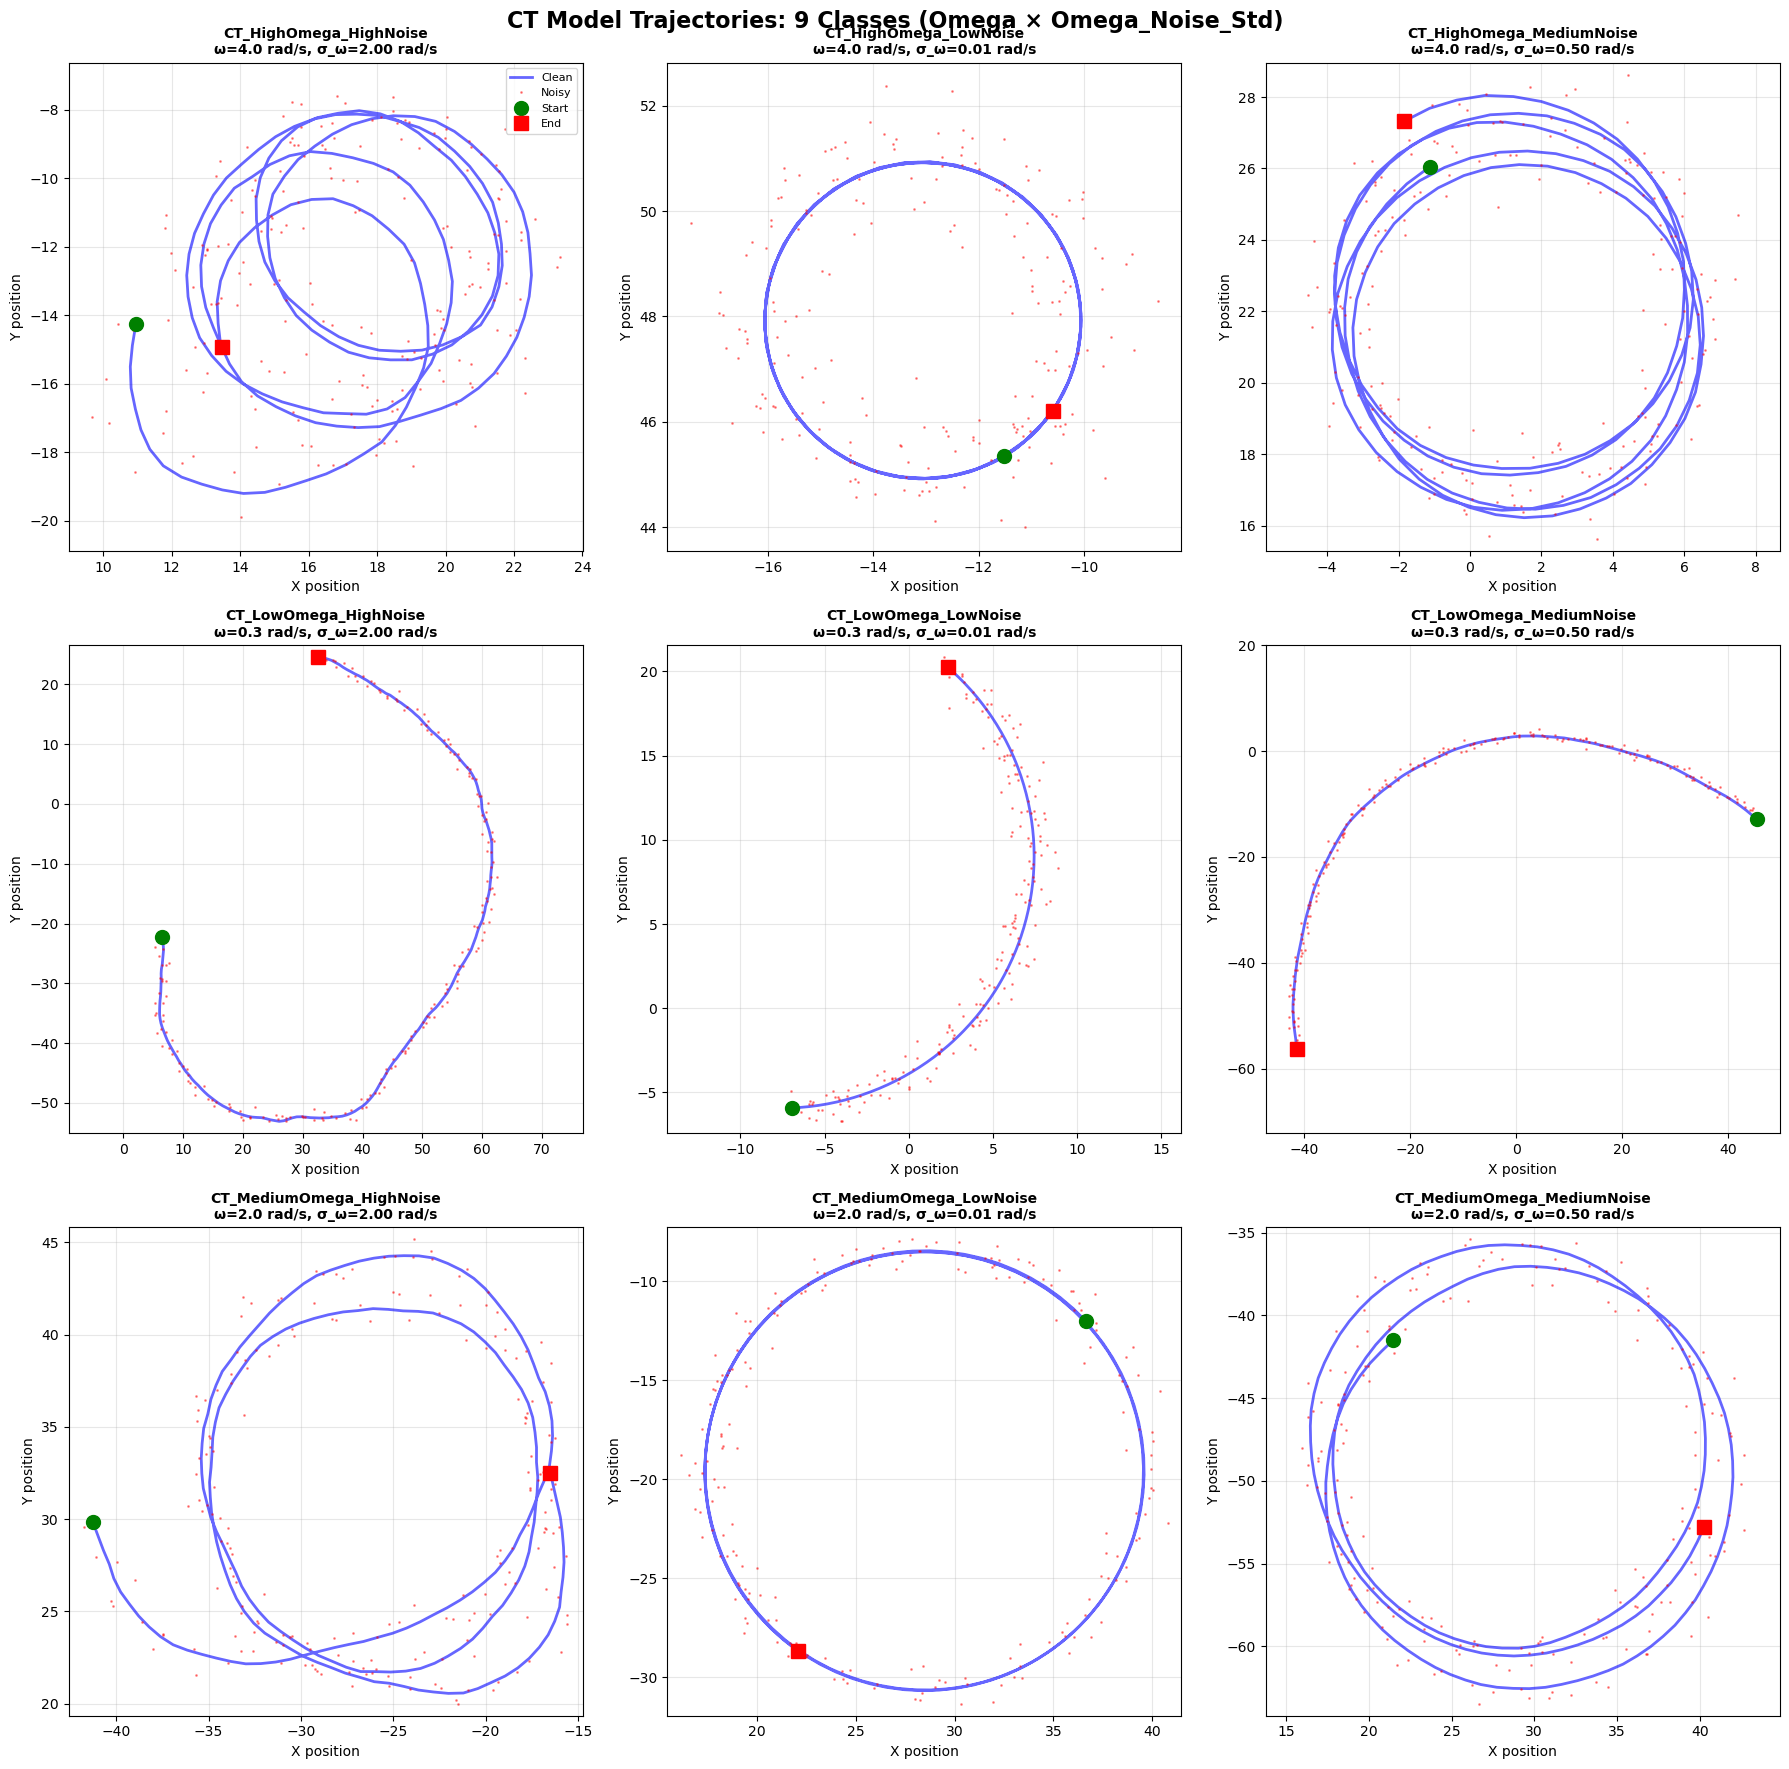


Trajectory Statistics by Class:
CT_HighOmega_HighNoise                   | ω=4.0 σ_ω=2.00 | Path Length:  249.9 ± 17.0
CT_HighOmega_LowNoise                    | ω=4.0 σ_ω=0.01 | Path Length:  244.2 ± 22.1
CT_HighOmega_MediumNoise                 | ω=4.0 σ_ω=0.50 | Path Length:  241.5 ± 21.3
CT_LowOmega_HighNoise                    | ω=0.3 σ_ω=2.00 | Path Length:  238.3 ± 17.5
CT_LowOmega_LowNoise                     | ω=0.3 σ_ω=0.01 | Path Length:  238.9 ± 16.9
CT_LowOmega_MediumNoise                  | ω=0.3 σ_ω=0.50 | Path Length:  238.4 ± 20.1
CT_MediumOmega_HighNoise                 | ω=2.0 σ_ω=2.00 | Path Length:  247.1 ± 17.9
CT_MediumOmega_LowNoise                  | ω=2.0 σ_ω=0.01 | Path Length:  241.7 ± 19.9
CT_MediumOmega_MediumNoise               | ω=2.0 σ_ω=0.50 | Path Length:  236.7 ± 20.9


In [96]:
# Visualize sample trajectories from different classes
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Select one trajectory from each class for visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('CT Model Trajectories: 9 Classes (Omega × Omega_Noise_Std)', fontsize=16, fontweight='bold')

class_names = sorted(set(m['class'] for m in ct_data['meta']))

for idx, (ax, class_name) in enumerate(zip(axes.flat, class_names)):
    # Find first trajectory of this class
    traj_idx = next(i for i, m in enumerate(ct_data['meta']) if m['class'] == class_name)
    
    noisy_traj = ct_data['X'][traj_idx]
    clean_traj = ct_data['Y'][traj_idx]
    meta = ct_data['meta'][traj_idx]
    
    # Extract omega and noise parameters
    omega = meta['params']['omega']
    omega_noise = meta['params']['omega_noise_std']
    
    # Plot trajectories
    ax.plot(clean_traj[:, 0], clean_traj[:, 1], 'b-', linewidth=2, alpha=0.6, label='Clean')
    ax.plot(noisy_traj[:, 0], noisy_traj[:, 1], 'r.', markersize=2, alpha=0.4, label='Noisy')
    
    # Mark start and end
    ax.plot(clean_traj[0, 0], clean_traj[0, 1], 'go', markersize=10, label='Start', zorder=5)
    ax.plot(clean_traj[-1, 0], clean_traj[-1, 1], 'rs', markersize=10, label='End', zorder=5)
    
    # Format
    ax.set_title(f'{class_name}\nω={omega:.1f} rad/s, σ_ω={omega_noise:.2f} rad/s', 
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    
    if idx == 0:
        ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

# Print trajectory statistics
print("\nTrajectory Statistics by Class:")
print("="*80)
for class_name in class_names:
    class_trajs = [ct_data['X'][i] for i, m in enumerate(ct_data['meta']) if m['class'] == class_name]
    
    # Calculate average path length
    path_lengths = []
    for traj in class_trajs:
        dists = np.sqrt(np.sum(np.diff(traj, axis=0)**2, axis=1))
        path_lengths.append(np.sum(dists))
    
    avg_path_length = np.mean(path_lengths)
    std_path_length = np.std(path_lengths)
    
    # Get parameters
    meta_sample = next(m for m in ct_data['meta'] if m['class'] == class_name)
    omega = meta_sample['params']['omega']
    omega_noise = meta_sample['params']['omega_noise_std']
    
    print(f"{class_name:40s} | ω={omega:.1f} σ_ω={omega_noise:.2f} | "
          f"Path Length: {avg_path_length:6.1f} ± {std_path_length:4.1f}")

print("="*80)


## Prepare Data for Chronos-2

**Important workflow:**
- Chronos receives **NOISY observations** (what sensors measure)
- Chronos predicts the next **NOISY observation**
- After prediction, we feed back the true **NOISY observation** (not prediction)
- Errors are calculated against **CLEAN ground truth** data

This mimics real tracking: sensors give noisy data, but we evaluate against true positions.


In [97]:
# Select a sample CT trajectory for testing Chronos forecasting
# Let's pick the first trajectory from the first class
trajectory = ct_data['X'][0]  # Shape: (200, 2) - 200 timesteps, 2D
true_trajectory = ct_data['Y'][0]  # Clean ground truth
sample_meta = ct_data['meta'][0]

print("="*60)
print("SAMPLE CT TRAJECTORY FOR CHRONOS TESTING")
print("="*60)
print(f"Class: {sample_meta['class']}")
print(f"Omega: {sample_meta['params']['omega']:.2f} rad/s (~{np.degrees(sample_meta['params']['omega']):.1f}°/s)")
print(f"Omega noise std: {sample_meta['params']['omega_noise_std']:.3f} rad/s")
print(f"Trajectory shape: {trajectory.shape}")
print(f"Number of timesteps: {trajectory.shape[0]}")
print(f"Dimensions: {trajectory.shape[1]}")
print()

# MULTIVARIATE FORECASTING: Handle X and Y coordinates together
# Chronos-2 supports multiple targets simultaneously!

dt = ct_config.dt  # Time step from config (0.04 seconds)
T = trajectory.shape[0]  # 200 timesteps

# Create timestamps
timestamps = pd.date_range(start='2025-01-01', periods=T, freq=f'{dt}s')

# NOISY observations for BOTH X and Y (what Chronos receives)
df_multivar_observed = pd.DataFrame({
    'item_id': ['trajectory_ct'] * T,
    'timestamp': timestamps,
    'x': trajectory[:, 0],  # X coordinate (noisy)
    'y': trajectory[:, 1]   # Y coordinate (noisy)
})

# CLEAN ground truth for BOTH X and Y (for error calculation)
df_multivar_clean = pd.DataFrame({
    'item_id': ['trajectory_ct'] * T,
    'timestamp': timestamps,
    'x': true_trajectory[:, 0],  # X coordinate (clean)
    'y': true_trajectory[:, 1]   # Y coordinate (clean)
})

print("="*60)
print("MULTIVARIATE DATA PREPARATION FOR CHRONOS")
print("="*60)
print(f"Total timesteps: {T}")
print(f"Duration: {T * dt:.1f} seconds")
print(f"Targets: ['x', 'y'] (simultaneous prediction)")
print()
print("NOISY observations (what Chronos sees):")
print(df_multivar_observed.head(5))
print()
print("CLEAN ground truth (for error calculation):")
print(df_multivar_clean.head(5))
print()

# Calculate noise levels
noise_x = np.std(trajectory[:, 0] - true_trajectory[:, 0])
noise_y = np.std(trajectory[:, 1] - true_trajectory[:, 1])
print(f"Noise level X: {noise_x:.4f}")
print(f"Noise level Y: {noise_y:.4f}")
print(f"Average noise: {(noise_x + noise_y) / 2:.4f}")


SAMPLE CT TRAJECTORY FOR CHRONOS TESTING
Class: CT_LowOmega_LowNoise
Omega: 0.30 rad/s (~17.2°/s)
Omega noise std: 0.010 rad/s
Trajectory shape: (200, 2)
Number of timesteps: 200
Dimensions: 2

MULTIVARIATE DATA PREPARATION FOR CHRONOS
Total timesteps: 200
Duration: 8.0 seconds
Targets: ['x', 'y'] (simultaneous prediction)

NOISY observations (what Chronos sees):
         item_id               timestamp         x         y
0  trajectory_ct 2025-01-01 00:00:00.000 -6.400657 -6.155325
1  trajectory_ct 2025-01-01 00:00:00.040 -6.987877 -4.925403
2  trajectory_ct 2025-01-01 00:00:00.080 -5.917342 -6.520373
3  trajectory_ct 2025-01-01 00:00:00.120 -6.855097 -6.170102
4  trajectory_ct 2025-01-01 00:00:00.160 -5.140663 -6.034434

CLEAN ground truth (for error calculation):
         item_id               timestamp         x         y
0  trajectory_ct 2025-01-01 00:00:00.000 -6.959088 -5.914986
1  trajectory_ct 2025-01-01 00:00:00.040 -6.780181 -5.906893
2  trajectory_ct 2025-01-01 00:00:00.080

## Multivariate Forecasting (Joint X-Y Prediction) - not batched


In [98]:
# Multivariate forecasting: Predict X and Y TOGETHER

if trajectory.shape[1] == 2:
    print("="*60)
    print("MULTIVARIATE FORECASTING (Joint X-Y Prediction)")
    print("="*60)
    
    # Prepare multivariate DataFrame with BOTH dimensions
    timestamps_mv = pd.date_range(start='2025-01-01', periods=T, freq=f'{dt}S')
    
    # NOISY observations for both X and Y
    df_multivar_observed = pd.DataFrame({
        'item_id': ['trajectory_2d'] * T,
        'timestamp': timestamps_mv,
        'x': trajectory[:, 0],  # X coordinate (noisy)
        'y': trajectory[:, 1]   # Y coordinate (noisy)
    })
    
    # CLEAN ground truth for both X and Y
    df_multivar_clean = pd.DataFrame({
        'item_id': ['trajectory_2d'] * T,
        'timestamp': timestamps_mv,
        'x': true_trajectory[:, 0],  # X coordinate (clean)
        'y': true_trajectory[:, 1]   # Y coordinate (clean)
    })
    
    print(f"\nMultivariate DataFrame (first 5 rows):")
    print(df_multivar_observed.head())
    
    # Iterative forecasting with MULTIPLE targets
    context_length_mv = 3
    predictions = []
    
    print(f"\nStarting joint X-Y forecasting (context={context_length_mv})...")
    print("This predicts X and Y simultaneously, capturing their correlations!\n")
    
    import time
    start_time_mv = time.time()
    
    # OPTIMIZATION: Use torch.inference_mode() for faster inference
    with torch.inference_mode():
        for i in range(context_length_mv, len(df_multivar_observed)):
            # Context includes BOTH X and Y history
            context_df = df_multivar_observed.iloc[:i].copy()
            
            # Predict BOTH X and Y together!
            pred_df = pipeline.predict_df(
                context_df,
                prediction_length=1,
                quantile_levels=[],  # Empty = only get mean prediction (faster)
                id_column='item_id',
                timestamp_column='timestamp',
                target=['x', 'y']  # ← MULTIPLE TARGETS!
            )
            
            # Extract predictions for both dimensions
            # pred_df will have columns like 'x[0.5]' and 'y[0.5]'
            predictions.append(pred_df['predictions'].values)
            
            # Progress indicator every 10 steps (reduce print overhead)
            print(f"Progress: {i - context_length_mv + 1}/{len(df_multivar_observed) - context_length_mv} ")
            
    multivar_results = {
        'predictions': predictions,
        'observed': ct_data["X"][0],
        'real': ct_data["Y"][0]
    }
else:
    print("Skipping multivariate forecasting (need 2D trajectory)")


MULTIVARIATE FORECASTING (Joint X-Y Prediction)

Multivariate DataFrame (first 5 rows):
         item_id               timestamp         x         y
0  trajectory_2d 2025-01-01 00:00:00.000 -6.400657 -6.155325
1  trajectory_2d 2025-01-01 00:00:00.040 -6.987877 -4.925403
2  trajectory_2d 2025-01-01 00:00:00.080 -5.917342 -6.520373
3  trajectory_2d 2025-01-01 00:00:00.120 -6.855097 -6.170102
4  trajectory_2d 2025-01-01 00:00:00.160 -5.140663 -6.034434

Starting joint X-Y forecasting (context=3)...
This predicts X and Y simultaneously, capturing their correlations!


C:\Users\ariel\AppData\Local\Temp\ipykernel_17664\4264286852.py:9: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps_mv = pd.date_range(start='2025-01-01', periods=T, freq=f'{dt}S')


KeyboardInterrupt: 

## Batched Prediction ##

In [ ]:
## 🎯 OPTIMAL: Multi-Trajectory Rolling Forecast with Batching

# This approach batches ACROSS trajectories while maintaining rolling forecast

print("="*60)
print("MULTI-TRAJECTORY ROLLING FORECAST (BATCHED)")
print("="*60)

# Generate multiple trajectories
n_trajectories = 180
#cfg_multi = default_config(dim=2)
#cfg_multi.classes[0].n_trajectories = n_trajectories
#data_multi = generate_dataset(cfg_multi)

print(f"\nProcessing {n_trajectories} trajectories with rolling forecast")
print(f"Trajectory shape: {ct_data['X'][0].shape}")

context_length_rolling = 3
T_rolling = ct_data['X'][0].shape[0]
n_predictions = T_rolling - context_length_rolling

# Storage for all predictions
all_predictions = []

import time
start_rolling = time.time()

# Rolling forecast: iterate through timesteps, batch across trajectories
with torch.inference_mode():
    for step in range(context_length_rolling, T_rolling):
        start_step = time.time()
        # Prepare contexts for ALL trajectories at THIS timestep
        contexts_this_step = []
        
        for traj_idx in range(n_trajectories):
            trajectory_data = ct_data['X'][traj_idx]
            
            # Context: all data up to current step
            context_data = trajectory_data[:step]
            timestamps = pd.date_range(start='2025-01-01', periods=step, freq='40ms')
            
            df_context = pd.DataFrame({
                'item_id': [f'traj_{traj_idx}'] * step,
                'timestamp': timestamps,
                'x': context_data[:, 0],
                'y': context_data[:, 1]
            })
            
            contexts_this_step.append(df_context)
        
        # Combine all trajectory contexts for this timestep
        combined_contexts = pd.concat(contexts_this_step, ignore_index=True)
        
        # ONE batch prediction for all trajectories at this timestep
        pred_df = pipeline.predict_df(
            combined_contexts,
            prediction_length=1,
            quantile_levels=[],
            id_column='item_id',
            timestamp_column='timestamp',
            target=['x', 'y']
        )
        
        # Store predictions
        all_predictions.append(pred_df)
        
        # Progress
        end_step = time.time()
        print(f"Step {step - context_length_rolling + 1}/{n_predictions} ::: time: {end_step - start_step}")

elapsed_rolling = time.time() - start_rolling

print(f"\n{'='*60}")
print(f"RESULTS")
print(f"{'='*60}")
print(f"Total time: {elapsed_rolling:.2f}s")
print(f"Time per step (batched across {n_trajectories} traj): {elapsed_rolling/n_predictions:.3f}s")
print(f"Effective time per trajectory-step: {elapsed_rolling/(n_predictions*n_trajectories):.3f}s")
print(f"\n🚀 Speedup: If done sequentially: {n_predictions * n_trajectories * 10:.0f}s")
print(f"   With batching: {elapsed_rolling:.0f}s")
print(f"   Speedup factor: ~{(n_predictions * n_trajectories * 10)/elapsed_rolling:.1f}x")


MULTI-TRAJECTORY ROLLING FORECAST (BATCHED)

Processing 180 trajectories with rolling forecast
Trajectory shape: (200, 2)
Step 1/197 ::: time: 13.903605461120605
Step 2/197 ::: time: 10.69145655632019
Step 3/197 ::: time: 12.210960388183594
Step 4/197 ::: time: 11.241003274917603
Step 5/197 ::: time: 11.260865926742554
Step 6/197 ::: time: 11.541543245315552
Step 7/197 ::: time: 11.407928705215454
Step 8/197 ::: time: 11.537398338317871
Step 9/197 ::: time: 11.266281604766846
Step 10/197 ::: time: 11.19822096824646
Step 11/197 ::: time: 11.412280082702637
Step 12/197 ::: time: 11.320746898651123
Step 13/197 ::: time: 11.461008548736572
Step 14/197 ::: time: 11.266598224639893
Step 15/197 ::: time: 11.927114009857178
Step 16/197 ::: time: 11.249380111694336
Step 17/197 ::: time: 12.324199199676514
Step 18/197 ::: time: 12.05203890800476


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000029717B293F0>
Traceback (most recent call last):
  File "C:\Users\ariel\anaconda3\envs\torch_env\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "C:\Users\ariel\anaconda3\envs\torch_env\lib\site-packages\torch\utils\data\dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "C:\Users\ariel\anaconda3\envs\torch_env\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "C:\Users\ariel\anaconda3\envs\torch_env\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


In [87]:
## 📦 Parse Batch Predictions into KF-Compatible Format

# Convert the batch predictions into list of numpy arrays (T, 2) per trajectory
# This matches the format you need for comparison with Kalman Filter

print("="*60)
print("PARSING BATCH PREDICTIONS")
print("="*60)

# all_predictions is a list of DataFrames, one per timestep
# Each DataFrame contains predictions for ALL trajectories at that timestep

print(f"\nRaw predictions: {len(all_predictions)} timesteps")
print(f"Example prediction DataFrame:")
print(all_predictions[0].head())

# Initialize storage: one list per trajectory
chronos_predictions_per_trajectory = [[] for _ in range(n_trajectories)]

# Parse predictions: iterate through timesteps
for step_idx, step_predictions in enumerate(all_predictions):
    # step_predictions is a DataFrame with one row per trajectory
    # Each row has: item_id, timestamp, predictions
    
    for traj_idx in range(n_trajectories):
        item_id = f'traj_{traj_idx}'
        
        # Find this trajectory's prediction in this timestep
        traj_row = step_predictions[step_predictions['item_id'] == item_id]
        
        if len(traj_row) > 0:
            # Extract [x, y] prediction
            pred_xy = traj_row['predictions'].values  # Shape: (2,) for [x, y]
            chronos_predictions_per_trajectory[traj_idx].append(pred_xy)

# Convert lists to numpy arrays
chronos_predictions_per_trajectory = [
    np.array(preds) for preds in chronos_predictions_per_trajectory
]

print(f"\n✓ Parsed predictions into {len(chronos_predictions_per_trajectory)} trajectory arrays")

# Verify the format
print(f"\nFormat verification:")
for traj_idx, preds in enumerate(chronos_predictions_per_trajectory):
    print(f"  Trajectory {traj_idx}: shape {preds.shape} (expected: ({n_predictions}, 2))")
    print(f"    First 3 predictions:")
    print(f"      {preds[:3]}")

# This is now ready for comparison with KF!
print(f"\n{'='*60}")
print(f"READY FOR KALMAN FILTER COMPARISON")
print(f"{'='*60}")
print(f"Variable: chronos_predictions_per_trajectory")
print(f"Format: List of {n_trajectories} numpy arrays")
print(f"Each array shape: ({n_predictions}, 2) for [x, y] predictions")
print(f"\nExample usage:")
print(f"  chronos_predictions_per_trajectory[0]  # First trajectory predictions")
print(f"  chronos_predictions_per_trajectory[0].shape  # Should be ({n_predictions}, 2)")


PARSING BATCH PREDICTIONS

Raw predictions: 197 timesteps
Example prediction DataFrame:
  item_id               timestamp target_name  predictions
0  traj_0 2025-01-01 00:00:00.120           x    -6.410156
1  traj_0 2025-01-01 00:00:00.120           y    -6.140625
2  traj_1 2025-01-01 00:00:00.120           x    46.781250
3  traj_1 2025-01-01 00:00:00.120           y    -3.466797
4  traj_2 2025-01-01 00:00:00.120           x     3.867188

✓ Parsed predictions into 180 trajectory arrays

Format verification:
  Trajectory 0: shape (197, 2) (expected: (197, 2))
    First 3 predictions:
      [[-6.4101562 -6.140625 ]
 [-6.6289062 -6.0351562]
 [-6.        -5.9414062]]
  Trajectory 1: shape (197, 2) (expected: (197, 2))
    First 3 predictions:
      [[46.78125   -3.4667969]
 [47.25      -2.9804688]
 [47.84375   -1.5292969]]
  Trajectory 2: shape (197, 2) (expected: (197, 2))
    First 3 predictions:
      [[ 3.8671875 -8.1796875]
 [ 3.5644531 -7.9882812]
 [ 2.2070312 -7.296875 ]]
  Trajecto

In [88]:
## 🔬 Compare Chronos with Kalman Filter

# Run KF on the same trajectories and compare MSE

print("="*60)
print("KALMAN FILTER COMPARISON")
print("="*60)

# Import KF
a = ct_data
from src.filters.ct_kalman_filter import CTKalmanFilter, InitializationData
dt = 0.04
# Get noise parameters from the first trajectory's metadata
#NOISE = np.array(data_multi["meta"][0]["params"]["measurement_noise_std"])
##NOISE = np.array([0.001, 0.001])
#PROCESS_NOISE_STD = np.array(data_multi["meta"][0]["params"]["vel_change_std"])
##PROCESS_NOISE_STD = np.array([0.001, 0.001])
#dt = cfg_multi.dt
#initial_velocity = np.array(data_multi["meta"][0]["initial_state"]["velocity"])

# Initialize KF
#initial_matrices_data = InitializationData(
#    observation_noise_std=NOISE, 
#    process_noise_std=PROCESS_NOISE_STD
#)


# Run KF on all trajectories
kf_predictions_per_trajectory = []
kf_mse_per_trajectory = []

print(f"\nRunning Kalman Filter on {n_trajectories} trajectories...")

for traj_idx in range(n_trajectories):
    # Get initial state
    initial_matrices_data = InitializationData(
    observation_noise_std=np.array(ct_data["meta"][traj_idx]["params"]["measurement_noise_std"]), 
    omega_std=ct_data["meta"][traj_idx]["params"]["omega_noise_std"],
    process_noise_std=np.array([0.000001, 0.000001])
    )

    kf = CTKalmanFilter(2, 7, 2, dt, initial_matrices_data)
    
    initial_omega = ct_data["meta"][traj_idx]["params"]["omega"]
    #initial_omega = 1
    initial_position = ct_data["X"][traj_idx][0]
    initial_velocity = np.array(ct_data["meta"][0]["initial_state"]["velocity"])
    x0 = np.array([initial_position[0], initial_velocity[0], 0,
                   initial_position[1], initial_velocity[1], 0, initial_omega])
    P0 = np.eye(7) * 1e1
    
    # Run KF with k=1 lag (1-step ahead prediction)
    kf.initialize(x0, P0)
    mse_kf, preds_kf = kf.run_k_lag(
        measurements=ct_data["X"][traj_idx],
        X0=x0,
        P0=P0,
        k=1,
        clean_signal=ct_data["Y"][traj_idx],
        normalize_mse=False
    )
    # Calculate MSE: Compare predictions to NOISY MEASUREMENTS (what we actually observe)
    noisy_measurements = ct_data["X"][traj_idx]
    mse_kf = ((noisy_measurements[context_length_rolling:] - preds_kf[context_length_rolling - 1:])**2).mean()
    # Store results (note: KF returns predictions starting from k+1)
    # We need to align with Chronos predictions which start from context_length_rolling
    kf_predictions_per_trajectory.append(preds_kf)
    kf_mse_per_trajectory.append(mse_kf)
    
    print(f"  Trajectory {traj_idx}: KF MSE = {mse_kf:.6f}")

# Calculate Chronos MSE for comparison
chronos_mse_per_trajectory = []

print(f"\nCalculating Chronos MSE...")

for traj_idx in range(n_trajectories):
    # Compare to NOISY MEASUREMENTS (what we actually observe), not clean truth
    noisy_measurements = ct_data["X"][traj_idx][context_length_rolling:]
    chronos_preds = chronos_predictions_per_trajectory[traj_idx]
    
    # Calculate MSE against actual measurements
    mse_chronos = ((noisy_measurements - chronos_preds)**2).mean()
    chronos_mse_per_trajectory.append(mse_chronos)
    
    print(f"  Trajectory {traj_idx}: Chronos MSE = {mse_chronos:.6f}")

# Summary comparison
print(f"\n{'='*60}")
print(f"COMPARISON SUMMARY")
print(f"{'='*80}")
print(f"\n📊 Evaluation Methodology:")
print(f"   Both models evaluated on predicting future OBSERVATIONS (noisy measurements)")
print(f"   MSE calculated against actual measurements, not hidden clean states")
print(f"   This is the fair comparison for real-world tracking scenarios")

avg_kf_mse = np.mean(kf_mse_per_trajectory)
avg_chronos_mse = np.mean(chronos_mse_per_trajectory)

print(f"\nAverage MSE across {n_trajectories} trajectories:")
print(f"  CT Kalman Filter: {avg_kf_mse:.6f}")
print(f"  Chronos-2:        {avg_chronos_mse:.6f}")

if avg_chronos_mse < avg_kf_mse:
    improvement = ((avg_kf_mse - avg_chronos_mse) / avg_kf_mse) * 100
    print(f"\n✓ Chronos is {improvement:.1f}% better than CT KF")
else:
    improvement = ((avg_chronos_mse - avg_kf_mse) / avg_kf_mse) * 100
    print(f"\n✗ CT KF is {improvement:.1f}% better than Chronos")

print(f"\nPer-Class Statistics:")
print("=" * 100)

# Group trajectories by class
from collections import defaultdict
class_results = defaultdict(lambda: {'kf_mse': [], 'chronos_mse': [], 'params': None})

for traj_idx in range(n_trajectories):
    meta = ct_data['meta'][traj_idx]
    class_name = meta['class']
    
    # Store MSEs
    class_results[class_name]['kf_mse'].append(kf_mse_per_trajectory[traj_idx])
    class_results[class_name]['chronos_mse'].append(chronos_mse_per_trajectory[traj_idx])
    
    # Store parameters (same for all trajectories in a class)
    if class_results[class_name]['params'] is None:
        class_results[class_name]['params'] = {
            'omega': meta['params']['omega'],
            'omega_noise_std': meta['params']['omega_noise_std'],
            'measurement_noise_std': meta['params']['measurement_noise_std']
        }

# Calculate and display statistics per class
print(f"{'Class':<40} | {'Omega':>6} | {'σ_ω':>6} | {'Avg KF MSE':>10} | {'Avg Chronos':>12} | Trajectory Wins (Chronos vs KF)")
print("-" * 120)

chronos_wins_by_class = 0
total_classes = len(class_results)

for class_name in sorted(class_results.keys()):
    results = class_results[class_name]
    
    avg_kf = np.mean(results['kf_mse'])
    avg_chronos = np.mean(results['chronos_mse'])
    
    # Count trajectory-by-trajectory wins
    chronos_wins = 0
    kf_wins = 0
    n_trajs = len(results['kf_mse'])
    
    for i in range(n_trajs):
        if results['chronos_mse'][i] < results['kf_mse'][i]:
            chronos_wins += 1
        else:
            kf_wins += 1
    
    # Determine which method won majority in this class
    if chronos_wins > kf_wins:
        chronos_wins_by_class += 1
    
    chronos_win_pct = (chronos_wins / n_trajs) * 100
    
    params = results['params']
    omega = params['omega']
    omega_noise = params['omega_noise_std']
    
    print(f"{class_name:<40} | {omega:6.2f} | {omega_noise:6.3f} | "
          f"{avg_kf:10.6f} | {avg_chronos:12.6f} | "
          f"Chronos: {chronos_wins:>2}/{n_trajs:<2} ({chronos_win_pct:5.1f}%) | KF: {kf_wins:>2}/{n_trajs}")

print("=" * 120)
print(f"\nClass-level summary (by majority wins):")
print(f"  Chronos wins majority in: {chronos_wins_by_class}/{total_classes} classes ({chronos_wins_by_class/total_classes*100:.1f}%)")
print(f"  KF wins majority in: {total_classes - chronos_wins_by_class}/{total_classes} classes ({(total_classes-chronos_wins_by_class)/total_classes*100:.1f}%)")

# Overall trajectory-level wins
counter_chronus_wins = sum(1 for i in range(n_trajectories) if chronos_mse_per_trajectory[i] < kf_mse_per_trajectory[i])
total_trajs = n_trajectories
print(f"\nOverall trajectory-level summary:")
print(f"  Chronos wins: {counter_chronus_wins}/{total_trajs} trajectories ({counter_chronus_wins/total_trajs*100:.1f}%)")
print(f"  KF wins: {total_trajs - counter_chronus_wins}/{total_trajs} trajectories ({(total_trajs-counter_chronus_wins)/total_trajs*100:.1f}%)")

# Create comprehensive data structure for further analysis
print(f"\n{'='*120}")
print("Creating comprehensive results data structure...")
print("=" * 120)

results_data = []

for traj_idx in range(n_trajectories):
    meta = ct_data['meta'][traj_idx]
    
    result_dict = {
        'trajectory_idx': traj_idx,
        'class': meta['class'],
        'omega': meta['params']['omega'],
        'omega_noise_std': meta['params']['omega_noise_std'],
        'measurement_noise_std': meta['params']['measurement_noise_std'],
        
        # Raw data
        'noisy_measurements': ct_data['X'][traj_idx],  # Shape: (T, 2)
        'true_values': ct_data['Y'][traj_idx],  # Shape: (T, 2)
        
        # Predictions (note: predictions start from context_length_rolling)
        'kf_predictions': kf_predictions_per_trajectory[traj_idx],  # Shape: (T-context_length, 2)
        'chronos_predictions': chronos_predictions_per_trajectory[traj_idx],  # Shape: (T-context_length, 2)
        
        # MSE scores
        'kf_mse': kf_mse_per_trajectory[traj_idx],
        'chronos_mse': chronos_mse_per_trajectory[traj_idx],
        
        # Winner
        'winner': 'Chronos' if chronos_mse_per_trajectory[traj_idx] < kf_mse_per_trajectory[traj_idx] else 'KF'
    }
    
    results_data.append(result_dict)

print(f"✓ Created results_data: list of {len(results_data)} dictionaries")
print(f"\nStructure of each dictionary:")
print(f"  - trajectory_idx: int")
print(f"  - class: str (e.g., 'CT_LowOmega_LowNoise')")
print(f"  - omega: float (turn rate in rad/s)")
print(f"  - omega_noise_std: float (turn rate noise)")
print(f"  - measurement_noise_std: array shape (2,)")
print(f"  - noisy_measurements: array shape (200, 2) - actual observations")
print(f"  - true_values: array shape (200, 2) - hidden clean states (for reference)")
print(f"  - kf_predictions: array shape (197, 2) - CT KF position predictions")
print(f"  - chronos_predictions: array shape (197, 2) - Chronos predictions")
print(f"  - kf_mse: float (MSE vs noisy measurements)")
print(f"  - chronos_mse: float (MSE vs noisy measurements)")
print(f"  - winner: str ('Chronos' or 'KF')")
print(f"\n⚠️  MSE scores are calculated against NOISY MEASUREMENTS, not clean truth")

print(f"\nExample - First trajectory:")
print(f"  Class: {results_data[0]['class']}")
print(f"  Omega: {results_data[0]['omega']:.2f} rad/s")
print(f"  KF MSE: {results_data[0]['kf_mse']:.6f}")
print(f"  Chronos MSE: {results_data[0]['chronos_mse']:.6f}")
print(f"  Winner: {results_data[0]['winner']}")
print(f"  Noisy measurements shape: {results_data[0]['noisy_measurements'].shape}")
print(f"  Predictions shape: {results_data[0]['chronos_predictions'].shape}")

print(f"\n✓ results_data is ready for further analysis, plotting, or export!")

KALMAN FILTER COMPARISON

Running Kalman Filter on 180 trajectories...
  Trajectory 0: KF MSE = 0.093513
  Trajectory 1: KF MSE = 0.165516
  Trajectory 2: KF MSE = 0.114670
  Trajectory 3: KF MSE = 0.164497
  Trajectory 4: KF MSE = 0.117981
  Trajectory 5: KF MSE = 0.100338
  Trajectory 6: KF MSE = 0.117955
  Trajectory 7: KF MSE = 2.843770
  Trajectory 8: KF MSE = 0.115030
  Trajectory 9: KF MSE = 0.198043
  Trajectory 10: KF MSE = 0.466772
  Trajectory 11: KF MSE = 0.230979
  Trajectory 12: KF MSE = 0.138981
  Trajectory 13: KF MSE = 0.136612
  Trajectory 14: KF MSE = 0.261088
  Trajectory 15: KF MSE = 0.121259
  Trajectory 16: KF MSE = 0.124469
  Trajectory 17: KF MSE = 0.114039
  Trajectory 18: KF MSE = 0.464881
  Trajectory 19: KF MSE = 0.180540
  Trajectory 20: KF MSE = 0.192292
  Trajectory 21: KF MSE = 0.118643
  Trajectory 22: KF MSE = 0.263626
  Trajectory 23: KF MSE = 0.179372
  Trajectory 24: KF MSE = 0.141249
  Trajectory 25: KF MSE = 0.138733
  Trajectory 26: KF MSE = 0.2

CT_MediumOmega_HighNoise
Chronos
[  2.84230904 -18.92068994]


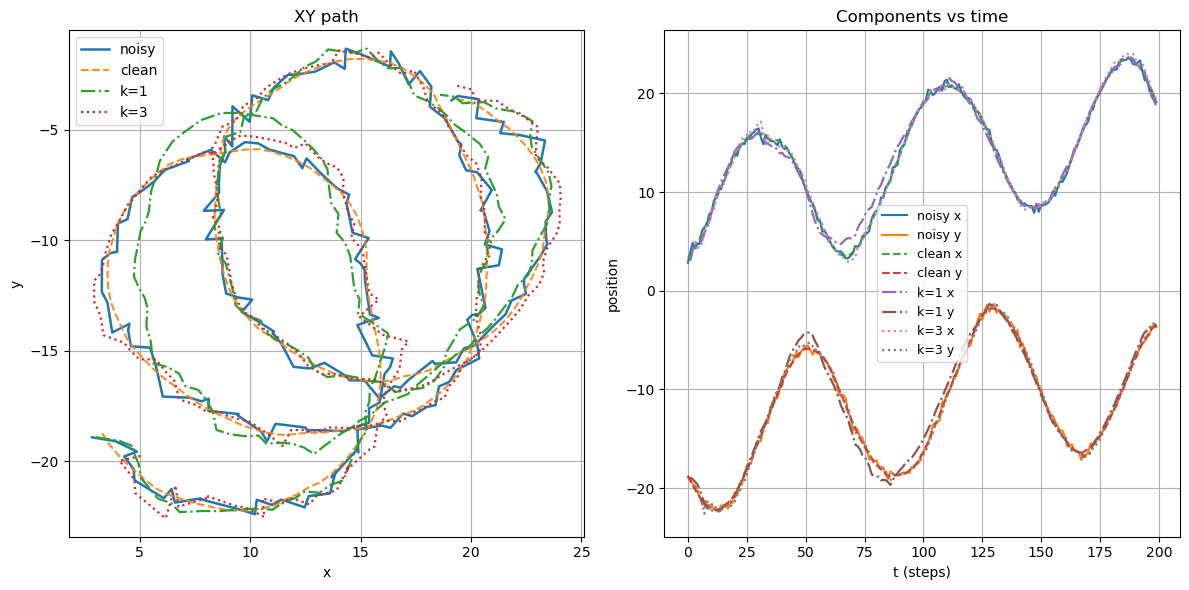

In [86]:
from src.visual.visual_tools import plot_trajectories_with_predictions_shifted

result = results_data[108]
print(result["class"])
print(result["winner"])
print(result["noisy_measurements"][0])
plot_trajectories_with_predictions_shifted(result["noisy_measurements"], result["true_values"], [(result["kf_predictions"], 1), (result["chronos_predictions"], 3)])